In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --upgrade numpy pandas tqdm torch catalyst==20.09

     |████████████████████████████████| 14.5MB 227kB/s 
     |████████████████████████████████| 10.5MB 41.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
     |████████████████████████████████| 460kB 39.4MB/s 
     |████████████████████████████████| 317kB 41.7MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.1

In [1]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

# GPU hack if you need
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Data

Columns
- `party_rk` – client unique identifier
- `account_rk` – client account unique identifier
- `financial_account_type_cd` – debit/credit card flag
- `transaction_dttm` – operation datetime
- `transaction_type_desc` – purchase/payment/...
- `transaction_amt_rur` – transaction price
- `merchant_type` - DUTY FREE STORES/FUEL DEALERS/RESTAURANTS/ etc
- `merchant_group_rk` - McDonald's/Wildberries/ etc

It's important that table is already sorted by `transaction_dttm` column!!!

In [2]:
DATADIR = "./hackathon_data" # "./data"
transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"
socdem_path = f"{DATADIR}/avk_hackathon_data_party_x_socdem.csv"
pd.read_csv(f"{DATADIR}/avk_hackathon_data_transactions.csv", nrows=5)

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


In [3]:
pd.read_csv(f"{DATADIR}/avk_hackathon_data_party_x_socdem.csv", nrows=5)

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


In [4]:
pd.read_csv(f"{DATADIR}/avk_hackathon_data_account_x_balance.csv", nrows=5)

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


In [5]:
pd.read_csv(f"{DATADIR}/avk_hackathon_data_party_products.csv", nrows=5)

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


## Mappings
~1 min

In [ ]:
# Prepare & save mappings
mappings = defaultdict(dict)
unk_token = "<UNK>"


def create_mapping(values):
    mapping = {unk_token: 0}
    for v in values:
        if not pd.isna(v):
            mapping[str(v)] = len(mapping)

    return mapping


for col in tqdm(
    [
        "transaction_type_desc",
        "merchant_rk",
        "merchant_type",
        "merchant_group_rk",
        "category",
        "financial_account_type_cd",
    ]
):

    col_values = (
        pd.read_csv(transactions_path, usecols=[col])[col]
        .fillna(unk_token)
        .astype(str)
    )
    mappings[col] = create_mapping(col_values.unique())
    del col_values


with open(f"{DATADIR}/mappings.json", "w") as f:
    json.dump(mappings, f)

In [3]:
# load mappings
with open(f"{DATADIR}/mappings.json", 'r') as f:
    mappings = json.load(f)

In [4]:
mappings.keys()

dict_keys(['transaction_type_desc', 'merchant_rk', 'merchant_type', 'merchant_group_rk', 'category', 'financial_account_type_cd'])

## Parse transactions by users
~ 40 min

In [ ]:
# Prepare & save client data
party2dates = defaultdict(list)  # for each party save a series of the transaction dates 
party2sum = defaultdict(list)  # for each party save a series of the transaction costs 
party2merchant_type = defaultdict(list)  # for each party save a series of the transaction_type 
party2trans_type = defaultdict(list)  # for each party save a series of the transaction merchant_type

usecols = [
    "party_rk",
    "transaction_dttm",
    "transaction_amt_rur",
    "merchant_type",
    "transaction_type_desc",
]

for chunk in tqdm(
    pd.read_csv(transactions_path, usecols=usecols, chunksize=100_000)
):

    chunk["merchant_type"] = (
        chunk["merchant_type"].fillna(unk_token).astype(str)
    )
    chunk["transaction_type_desc"] = (
        chunk["transaction_type_desc"].fillna(unk_token).astype(str)
    )
    chunk["transaction_amt_rur"] = chunk["transaction_amt_rur"].fillna(0)

    for i, row in chunk.iterrows():
        party2dates[row.party_rk].append(row.transaction_dttm)
        party2sum[row.party_rk].append(row.transaction_amt_rur)
        party2merchant_type[row.party_rk].append(
            mappings["merchant_type"][row.merchant_type]
        )
        party2trans_type[row.party_rk].append(
            mappings["transaction_type_desc"][row.transaction_type_desc]
        )

    del chunk

pickle.dump(party2dates, open(f"{DATADIR}/party2dates.pkl", "wb"))
pickle.dump(party2sum, open(f"{DATADIR}/party2sum.pkl", "wb"))
pickle.dump(party2merchant_type, open(f"{DATADIR}/party2merchant_type.pkl", "wb"))
pickle.dump(party2trans_type, open(f"{DATADIR}/party2trans_type.pkl", "wb"))

In [5]:
# load client data
party2dates = pickle.load(open(f"{DATADIR}/party2dates.pkl", 'rb'))
party2sum = pickle.load(open(f"{DATADIR}/party2sum.pkl", 'rb'))
party2merchant_type = pickle.load(open(f"{DATADIR}/party2merchant_type.pkl", 'rb'))
party2trans_type = pickle.load(open(f"{DATADIR}/party2trans_type.pkl", 'rb'))

In [68]:
# Prepare & save client data
party2socialfeats = defaultdict(list)  # for each party save a series of the transaction dates 


usecols = [
    "party_rk",
    "gender_cd",
    "age",
    "marital_status_desc",
    "children_cnt",
    "region_flg"
]

for chunk in tqdm(
    pd.read_csv(socdem_path, usecols=usecols, chunksize=100_000)
):

    chunk["marital_status_desc"] = (
        chunk["marital_status_desc"].fillna('Иннопланетяне').astype('category').cat.codes
    )
    
    chunk["gender_cd"] = (
        chunk["gender_cd"].astype('category').cat.codes
    )
    
    chunk.dropna()

    for i, row in chunk.iterrows():
        party2socialfeats[row.party_rk] = [row.gender_cd, row.age, row.marital_status_desc, 
                                           row.children_cnt, row.region_flg]
        
    del chunk

pickle.dump(party2socialfeats, open(f"{DATADIR}/party2socialfeats.pkl", "wb"))

1it [00:05,  5.22s/it]


In [6]:
# load client data
party2socialfeats = pickle.load(open(f"{DATADIR}/party2socialfeats.pkl", 'rb'))

## PyTorch dataset

In [7]:
from sklearn.model_selection import train_test_split

train_party, valid_party = train_test_split(
    pd.read_csv(transactions_path, usecols=['party_rk']).party_rk.unique(), 
    train_size=0.8, random_state=42
)

print(f'Train: {len(train_party)} Val: {len(valid_party)}')

Train: 40000 Val: 10000


In [8]:
predict_period_len = 60  # -- days
train_predict_dates = (
    pd.date_range("2019-03-01", "2019-10-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
valid_predict_dates = (
    pd.date_range("2019-11-01", "2019-12-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
submission_predict_dates = (
    pd.date_range("2020-01-01", "2020-02-28", freq="2MS")
    .strftime("%Y-%m-%d")
    .tolist()
)

In [9]:
train_predict_dates, valid_predict_dates, submission_predict_dates

(['2019-03-01',
  '2019-04-01',
  '2019-05-01',
  '2019-06-01',
  '2019-07-01',
  '2019-08-01',
  '2019-09-01',
  '2019-10-01'],
 ['2019-11-01', '2019-12-01'],
 ['2020-01-01'])

In [10]:
def prepare_data(party_list, mode="train"):
    """
    This function define the pipeline of the creation of train and valid samples.
    We consider each client from party_list. For each client take each 
    predict_period_start from predict_dates list. All client transaction before
    this date is our features. Next, we look at the customer's transactions in 
    the next two months. This transactions should be predicted. It will form 
    our labels vector.
    """

    data_sum = []
    data_trans_type = []
    data_merchant_type = []
    data_labels = []
    data_social_info = []

    for party_rk in tqdm(party_list):
        date_series = party2dates[party_rk]
        sum_series = party2sum[party_rk]
        merch_type_series = party2merchant_type[party_rk]
        trans_type_series = party2trans_type[party_rk]
        
        social_info = party2socialfeats[party_rk]

        if mode == "train":
            predict_dates = train_predict_dates
        elif mode == "valid":
            predict_dates = valid_predict_dates
        elif mode == "submission":
            predict_dates = submission_predict_dates
        else:
            raise Exception("Unknown mode")

        for predict_period_start in predict_dates:

            predict_period_end = datetime.strftime(
                datetime.strptime(predict_period_start, "%Y-%m-%d")
                + timedelta(days=predict_period_len),
                "%Y-%m-%d",
            )

            l, r = (
                bisect_left(date_series, predict_period_start),
                bisect_right(date_series, predict_period_end),
            )

            history_merch_type = merch_type_series[:l]
            history_sum = sum_series[:l]
            history_trans_type = trans_type_series[:l]
            predict_merch = merch_type_series[l:r]

            if predict_merch and l or mode not in ("train", "valid"):
                data_sum.append(history_sum)
                data_trans_type.append(history_trans_type)
                data_merchant_type.append(history_merch_type)
                data_labels.append(predict_merch)
                data_social_info.append(social_info)

    return data_sum, data_trans_type, data_merchant_type, data_social_info, data_labels

In [11]:
train_sum, train_trans_type, train_merchant_type, train_social_info, train_labels = prepare_data(
    train_party, mode="train"
)
valid_sum, valid_trans_type, valid_merchant_type, valid_social_info, valid_labels = prepare_data(
    valid_party, mode="valid"
)

100%|██████████| 10000/10000 [00:00<00:00, 15387.59it/s]


In [12]:
len(train_sum), len(train_trans_type), len(train_merchant_type), len(train_labels)

(243346, 243346, 243346, 243346)

## PyTorch loaders

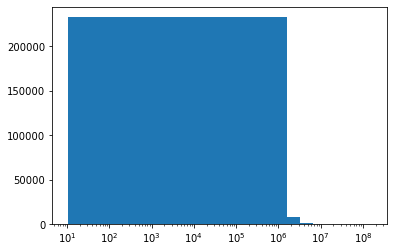

In [13]:
import matplotlib.pyplot as plt

lengths = []
for user_sum in train_sum:
    lengths += [np.sum(user_sum)]

_ = plt.hist(lengths, bins=100)
plt.xscale('log')

In [14]:
lengths = np.array(lengths)

lengths[lengths > 1e7].shape, lengths.shape


((192,), (243346,))

In [15]:
lengths

array([ 70986.  , 178746.  , 375351.16, ..., 120583.96, 131183.96,
       131512.26])

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader

In [18]:
MERCH_TYPE_NCLASSES = len(mappings['merchant_type'])
TRANS_TYPE_NCLASSES = len(mappings['transaction_type_desc'])
PADDING_LEN = 300

In [24]:
class RSDataset(Dataset):
    def __init__(self, data_sum, data_trans_type, data_merchant_type, data_social_info, labels):
        super(RSDataset, self).__init__()
        self.data_sum = data_sum
        self.data_trans_type = data_trans_type
        self.data_merchant_type = data_merchant_type
        self.data_social_info = data_social_info
        self.labels = labels

    def __len__(self):
        return len(self.data_sum)

    def __getitem__(self, idx):
        targets = np.zeros((MERCH_TYPE_NCLASSES - 1,), dtype=np.float32)
        for m in self.labels[idx]:
            if m:  # skip UNK, UNK-token should not be predicted
                targets[m - 1] = 1.0

        item = {
            "features": {},
            "targets": targets,
        }

        sum_feature = np.array(self.data_sum[idx][-PADDING_LEN:])
        sum_feature = np.vectorize(lambda s: np.log(1 + s))(sum_feature)
        if sum_feature.shape[0] < PADDING_LEN:
            pad = np.zeros(
                (PADDING_LEN - sum_feature.shape[0],), dtype=np.float32
            )
            sum_feature = np.hstack((sum_feature, pad))
        item["features"]["sum"] = torch.from_numpy(sum_feature).float()
        item["features"]["social_info"] = torch.from_numpy(np.array(self.data_social_info)[idx]).long()
        
        for feature_name, feature_values in zip(
            ["trans_type", "merchant_type"],
            [self.data_trans_type[idx], self.data_merchant_type[idx]],
        ):

            feature_values = np.array(feature_values[-PADDING_LEN:])
            mask = np.ones(feature_values.shape[0], dtype=np.float32)
            if feature_values.shape[0] < PADDING_LEN:
                feature_values = np.append(
                    feature_values,
                    np.zeros(
                        PADDING_LEN - feature_values.shape[0], dtype=np.int64
                    ),
                )
                mask = np.append(
                    mask,
                    np.zeros(PADDING_LEN - mask.shape[0], dtype=np.float32),
                )
            item["features"][feature_name] = torch.from_numpy(feature_values).long()
            item["features"][f"{feature_name}_mask"] = torch.from_numpy(mask).float()
                

        return item

In [25]:
train_dataset = RSDataset(
    train_sum, train_trans_type, train_merchant_type, train_social_info, train_labels
)
valid_dataset = RSDataset(
    valid_sum, valid_trans_type, valid_merchant_type, valid_social_info, valid_labels
)


In [26]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=2
)

In [28]:
# sanity check
for i in tqdm(range(len(train_loader))):
    batch = next(iter(train_loader))
    print(batch['features'].keys())
    print(batch['features']['merchant_type'].shape)
    print(batch['features']['sum'])
    print(batch['features']['trans_type'])
    print(batch['targets'].shape)
    print(batch['targets'])
    print(batch['features']['trans_type'][0], batch['features']['trans_type_mask'][0])
    print(batch['features']['social_info'][0])
    break

  0%|          | 0/3803 [00:39<?, ?it/s]

dict_keys(['sum', 'social_info', 'trans_type', 'trans_type_mask', 'merchant_type', 'merchant_type_mask'])
torch.Size([64, 300])
tensor([[6.8658, 5.4889, 5.5683,  ..., 0.0000, 0.0000, 0.0000],
        [9.2687, 6.5058, 5.5683,  ..., 0.0000, 0.0000, 0.0000],
        [8.9360, 7.7940, 6.4865,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [8.0944, 6.9344, 7.9241,  ..., 0.0000, 0.0000, 0.0000],
        [7.6620, 7.6643, 4.0690,  ..., 0.0000, 0.0000, 0.0000],
        [8.1014, 6.0331, 3.0445,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [3, 3, 2,  ..., 0, 0, 0],
        [4, 3, 1,  ..., 0, 0, 0],
        ...,
        [1, 3, 3,  ..., 0, 0, 0],
        [3, 3, 1,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])
torch.Size([64, 457])
tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0., 

In [38]:
batch['features']['social_info'].shape

torch.Size([64, 5])

In [43]:
np.tile(batch['features']['social_info'],(300,1)).reshape(64, 300, 5)[0]

array([[ 1, 30,  2,  0,  0],
       [ 1, 35,  2,  0,  0],
       [ 0, 60,  1,  1,  0],
       ...,
       [ 0, 30,  2,  0,  0],
       [ 1, 30,  3,  0,  0],
       [ 1, 40,  5,  0,  0]])

In [44]:
batch['features']['social_info'][0]

tensor([ 1, 30,  2,  0,  0])

## Model

This is the baseline model for predicting purchases in `merchant_type` in the next 2 months

In [32]:
import torch.nn as nn
from collections import OrderedDict

In [33]:
params = {
    'merchant_type_emb_dim': 64,
    'trans_type_embedding': 3,
    'transformer_nhead': 4,
    'transformer_dim_feedforward': 256,
    'transformer_dropout': 0.2,
    'dense_unit': 256,
    'num_layers': 4,
}

In [34]:
SOCIAL_NCLASSES = np.array(train_social_info).shape[1]

In [35]:
MERCH_TYPE_NCLASSES, TRANS_TYPE_NCLASSES, SOCIAL_NCLASSES

(458, 5, 5)

In [36]:
from torch.nn.modules.normalization import LayerNorm

In [37]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.merchant_type_embedding = nn.Embedding(
            MERCH_TYPE_NCLASSES, params["merchant_type_emb_dim"]
        )
        self.trans_type_embedding = nn.Embedding(
            TRANS_TYPE_NCLASSES, params["trans_type_embedding"]
        )

        embedding_size = (
            params["merchant_type_emb_dim"]
            + params["trans_type_embedding"]
            + 1 + SOCIAL_NCLASSES
        )
        
        transformer_block = nn.TransformerEncoderLayer(d_model=embedding_size,
                                                        nhead=params["transformer_nhead"],
                                                        dim_feedforward=params["transformer_dim_feedforward"],
                                                        dropout=params["transformer_dropout"])
        self.transformer_encoder = nn.TransformerEncoder(transformer_block, 
                                                         params["num_layers"], 
                                                         LayerNorm(embedding_size))

        self.linear = nn.Linear(
            in_features=embedding_size, out_features=params["dense_unit"]
        )
        self.scorer = nn.Linear(
            in_features=params["dense_unit"],
            out_features=MERCH_TYPE_NCLASSES - 1,
        )

    def forward(self, features):

        merchant_type_emb = self.merchant_type_embedding(features["merchant_type"])
        trans_type_emb = self.trans_type_embedding(features["trans_type"])

        merchant_type_emb = merchant_type_emb * features["merchant_type_mask"].unsqueeze(-1)
        trans_type_emb = trans_type_emb * features["trans_type_mask"].unsqueeze(-1)

        embeddings = torch.cat(
            (merchant_type_emb, trans_type_emb, features["sum"].unsqueeze(-1)),
            dim=-1,
        )

        transformer_output = self.transformer_encoder(embeddings)
        pooling = torch.mean(transformer_output, dim=1)
        linear = torch.tanh(self.linear(pooling))
        merch_logits = self.scorer(linear)

        return merch_logits

### One-batch-check

In [38]:
model = Model()
criterion = nn.BCEWithLogitsLoss()
batch = next(iter(train_loader))
output = model(batch['features'])
loss = criterion(output, batch['targets'])
print(loss)

torch.Size([64, 300, 64]) torch.Size([64, 300, 3]) torch.Size([64, 300, 1])
tensor(0.6986, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


## Train loop with [Catalyst](https://github.com/catalyst-team/catalyst)

[A comprehensive step-by-step guide to basic and advanced features](https://github.com/catalyst-team/catalyst#step-by-step-guide).

---



In [103]:
from catalyst import dl, utils
from catalyst.utils import metrics

## Custom metrics for this hackathon

In [104]:
from typing import List, Optional, Sequence, Tuple, Union

import numpy as np
import torch
from catalyst.utils.metrics.functional import preprocess_multi_label_metrics
from catalyst.utils.torch import get_activation_fn


def multi_label_metrics(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    threshold: Union[float, torch.Tensor],
    activation: Optional[str] = None,
    eps: float = 1e-7,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes multi-label precision for the specified activation and threshold.

    Args:
        outputs (torch.Tensor): NxK tensor that for each of the N examples
            indicates the probability of the example belonging to each of
            the K classes, according to the model.
        targets (torch.Tensor): binary NxK tensort that encodes which of the K
            classes are associated with the N-th input
            (eg: a row [0, 1, 0, 1] indicates that the example is
            associated with classes 2 and 4)
        threshold (float): threshold for for model output
        activation (str): activation to use for model output
        eps (float): epsilon to avoid zero division
    
    Extended version of 
        https://github.com/catalyst-team/catalyst/blob/master/catalyst/utils/metrics/accuracy.py#L58

    Returns:
        computed multi-label metrics
    """
    outputs, targets, _ = preprocess_multi_label_metrics(
        outputs=outputs, targets=targets
    )
    activation_fn = get_activation_fn(activation)
    outputs = activation_fn(outputs)

    outputs = (outputs > threshold).long()

    accuracy = (targets.long() == outputs.long()).sum().float() / np.prod(
        targets.shape
    )

    intersection = (outputs.long() * targets.long()).sum(axis=1).float()
    num_predicted = outputs.long().sum(axis=1).float()
    num_relevant = targets.long().sum(axis=1).float()
    union = num_predicted + num_relevant

    # Precision = ({predicted items} && {relevant items}) / {predicted items}
    precision = intersection / (num_predicted + eps * (num_predicted == 0))
    # Recall = ({predicted items} && {relevant items}) / {relevant items}
    recall = intersection / (num_relevant + eps * (num_relevant == 0))
    # IoU = ({predicted items} && {relevant items}) / ({predicted items} || {relevant items})
    iou = (intersection + eps * (union == 0)) / (union - intersection + eps)

    return accuracy, precision.mean(), recall.mean(), iou.mean()


def precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
):
    """
    Computes precision at cutoff k for one sample

    Args:
       actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
       predicted (torch.Tensor): binary tensor that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       k (int): parameter k of precison@k

    Returns:
       Computed value of precision@k for given sample
    """
    p_at_k = 0.0
    for item in predicted[:k]:
        if actual[item]:
            p_at_k += 1
    p_at_k /= k

    return p_at_k


def average_precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
) -> float:
    """
    Computes average precision at cutoff k for one sample

    Args:
      actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
      predicted (torch.Tensor): binary tensor that encodes which of the K
          classes are associated with the N-th input
          (eg: a row [0, 1, 0, 1] indicates that the example is
          associated with classes 2 and 4)
      k (int): parameter k of AP@k

    Returns:
        Computed value of AP@k for given sample
    """
    ap_at_k = 0.0
    for idx, item in enumerate(predicted[:k]):
        if actual[item]:
            ap_at_k += precision_at_k(actual, predicted, k=idx + 1)
    ap_at_k /= min(k, actual.sum().cpu().numpy())
    

    return ap_at_k


def mean_average_precision_at_k(
    output: torch.Tensor, target: torch.Tensor, top_k: Tuple[int, ...] = (1,)
) -> List[float]:
    """
    Computes mean_average_precision_at_k at set of cutoff parameters K

    Args:
       outputs (torch.Tensor): NxK tensor that for each of the N examples
           indicates the probability of the example belonging to each of
           the K classes, according to the model.
       targets (torch.Tensor): binary NxK tensort that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       top_k (tuple): list of parameters k at which map@k will be computed


    Returns:
       List of computed values of map@k at each cutoff k from topk
    """
    max_k = max(top_k)
    batch_size = target.size(0)

    _, top_indices = output.topk(k=max_k, dim=1, largest=True, sorted=True)

    result = []
    for k in top_k:  # loop over k
        map_at_k = 0.0
        for actual_target, predicted_items in zip(
            target, top_indices
        ):  # loop over samples
            map_at_k += average_precision_at_k(
                actual_target, predicted_items, k
            )
        map_at_k = map_at_k / batch_size
        result.append(map_at_k)

    return result

In [105]:
# What is Runner?
# https://catalyst-team.github.io/catalyst/api/core.html#runner
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch["features"], batch["targets"]
        logits = self.model(features)
        scores = torch.sigmoid(logits)

        loss = self.criterion(logits, targets)
        accuracy, precision, recall, iou = multi_label_metrics(
            logits, targets, threshold=0.5, activation="Sigmoid"
        )
        map05, map10, map20 = mean_average_precision_at_k(
            scores, targets, top_k=(5, 10, 20)
        )
        batch_metrics = {
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "iou": iou,
            "map05": map05,
            "map10": map10,
            "map20": map20
        }
        
        self.input = {"features": features, "targets": targets}
        self.output = {"logits": logits, "scores": scores}
        self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def predict_batch(self, batch):
        # model inference step
        batch = utils.maybe_recursive_call(batch, "to", device=self.device)
        logits = self.model(batch["features"])
        scores = torch.sigmoid(logits)
        return scores

In [106]:
model = Model()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loaders = {"train": train_loader, "valid": valid_loader}

In [107]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 501), started 1:55:12 ago. (Use '!kill 501' to kill it.)

In [ ]:
# For other minimal examples, please follow the link below
# https://github.com/catalyst-team/catalyst#minimal-examples
runner = CustomRunner()
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    loaders=loaders,
    logdir="./logs",
    num_epochs=10,
    verbose=True,
    load_best_on_end=True,
    overfit=False,  #  <<<--- DO NOT FORGET TO MAKE IT ``False`` 
                    #  (``True`` uses only one batch to check pipeline correctness)
    callbacks=[
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
        # dl.AveragePrecisionCallback(input_key="targets", output_key="scores", prefix="ap"),
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
        # dl.AUCCallback(input_key="targets", output_key="scores", prefix="auc"),
    ],
    main_metric="iou", # "ap/mean", 
    minimize_metric=False,
)

1/10 * Epoch (train):   9% 326/3803 [01:38<18:00,  3.22it/s, accuracy=0.976, iou=0.223, loss=0.070, map05=0.613, map10=0.515, map20=0.480, precision=0.664, recall=0.342]

In [ ]:
# model inference example
# for prediction in runner.predict_loader(loader=loaders["valid"]):
#     assert prediction.detach().cpu().numpy().shape[-1] == MERCH_TYPE_NCLASSES-1

In [ ]:
# import plotly  # required for contrib
# from catalyst.contrib.utils import plot_tensorboard_log

# plot_tensorboard_log(logdir="./logs", step="batch")

In [ ]:
import plotly  # required for contrib
from catalyst.contrib.utils import plot_tensorboard_log

plot_tensorboard_log(
    logdir="./logs", 
    step="epoch", 
    metrics=[
        "loss", "accuracy", "precision", "recall", "iou", 
        "map05", "map10", "map20",
        "ap/mean", "auc/mean"
    ]
)

## Your task

We suggest you to improve this baseline. Feel free to use any kind of model architectures, loss functions, inputs, etc. in your experiments.


YOUR TASK is to predict purchases in `merchant_type` in **January-February 2020** for all the clients (50k) from the given dataset.

SUBMISSION FORMAT: You should submit a `.csv` file in the following format. 

The submission file should contain two columns:
* `party_rk` -- client unique identifier
* `recommendations` -- list of the **top 30** predicted `merchant_type`, sorted by predicted proba (pay attention!) **separated by commas**. 

The `.csv` file separator should be **semicolon (";")**. The submission file example can be generated by the pipeline shown below.

EVALUATION: Your submission will be evaluated by metric **MAP@30**. Scores for this part of the hackathon will be given according to the value of this metric.

Good luck!

## Submission file example

In [ ]:
# create data loader for submission
full_party = pd.read_csv(transactions_path, usecols=['party_rk']).party_rk.unique()
full_sum, full_trans_type, full_merchant_type, full_labels = prepare_data(
    full_party, mode="submission"
)
full_dataset = RSDataset(
   full_sum, full_trans_type, full_merchant_type, full_labels
)
full_loader = DataLoader(
    full_dataset, batch_size=64, shuffle=False, num_workers=8, drop_last=False)

In [ ]:
# get predictions from the model
predictions = []
for scores in tqdm(runner.predict_loader(loader=full_loader), total = len(full_loader)):
    _, top_indices = scores.topk(k=30, dim=1, largest=True, sorted=True)
    top_indices += 1
    predictions += top_indices.detach().cpu().tolist()

In [ ]:
# inverse mapping for merchant_type in predictions
merchant_type_inverse_mapping = {k: v for v, k in mappings['merchant_type'].items()}
def inverse_mapping(x):
    return list(map(merchant_type_inverse_mapping.get, x))

predictions = list(map(inverse_mapping, predictions))

In [ ]:
# create submission table
submission = pd.DataFrame({
    "party_rk" : full_party, 
    "recommendations" : predictions
})
submission['recommendations'] = submission['recommendations'].apply(lambda x: ",".join(map(str, x)))

submission.to_csv('submission_[TEAM_NAME].csv', index=False, sep=";")